In [1]:
import pandas as pd
from six.moves import urllib
import time
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 20)
pd.set_option('display.float_format', lambda x: "{0:,.3f}".format(x))

In [31]:
# Seattle house price index
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=SEXRNSA&scale=left&cosd=1990-01-01&coed=2021-12-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-03-22&revision_date=2019-03-22&nd=1990-01-01"

f = urllib.request.urlopen(url)
all_lines = f.read().decode('utf-8')

nested_alines = [line.split(',') for line in all_lines.split('\n')[1:]]
cols = all_lines.split('\n')[0].split(',')
adf = pd.DataFrame.from_records(nested_alines[:-1], columns=cols)
adf['DATE'] = pd.to_datetime(adf['DATE'])
adf['SEXRNSA'] = adf['SEXRNSA'].astype(float)
adf

,DATE,SEXRNSA
0,1990-01-01,58.233
1,1990-02-01,59.977
2,1990-03-01,62.294
3,1990-04-01,65.092
4,1990-05-01,66.825
5,1990-06-01,68.063
6,1990-07-01,68.299
7,1990-08-01,68.607
8,1990-09-01,68.134
9,1990-10-01,67.586


<AxesSubplot:xlabel='DATE'>

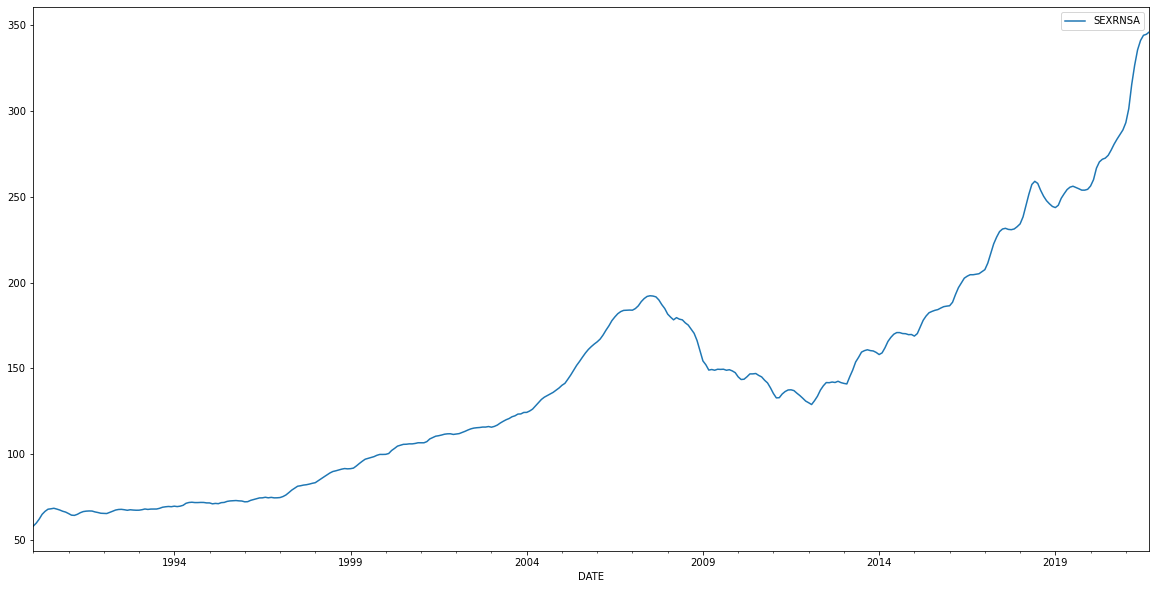

In [32]:
adf.set_index('DATE').plot(figsize=(20,10))

In [5]:
# we invest same amount of money to both Real Estate and Stock market, to see the difference
every_year_investment = 12000.0

In [7]:
# Assume interset rate is 3% for 30-year fixed 
# https://www.nerdwallet.com/mortgages/mortgage-rates

# We are going to spend $1000 a month, $12,000 a year. How much loan get we get?
loan_amount = npf.pv(0.03, 30, -every_year_investment, 0)
loan_amount

235205.29619363745

In [8]:
# assume we put 20% down, and loan 80%
# the home we can afford is

home_price = loan_amount/0.8
home_price

294006.6202420468

In [9]:
downpay = home_price - loan_amount
downpay

58801.324048409326

In [10]:
# Assume we buy the property in 1990, and now is 2018. 
# What's the home value now?
purchase_index = adf.iloc[0]["SEXRNSA"]
print("Purchase Index: {0:.3f}".format(purchase_index))
current_index = adf.iloc[-1]["SEXRNSA"]
print("Current Index: {0:.3f}".format(current_index))

current_value = home_price/purchase_index*current_index
print("Current Value: {0:,.2f}".format(current_value))

Purchase Index: 58.233
Current Index: 345.886
Current Value: 1,746,298.72


In [11]:
# property tax, assuming 0.8%
property_tax_rate = 0.008

purchase_index = adf.iloc[0]["SEXRNSA"]
adf['Year'] = adf['DATE'].map(lambda x:x.year)
average_home_value_per_year = adf.groupby('Year')['SEXRNSA'].agg(['mean'])
average_home_value_per_year['PropertyTax'] = home_price / purchase_index * average_home_value_per_year['mean']*property_tax_rate
average_home_value_per_year

,mean,PropertyTax
Year,,
1990,65.531,"2,646.797"
1991,65.972,"2,664.616"
1992,67.135,"2,711.603"
1993,68.522,"2,767.610"
1994,71.230,"2,876.978"
...,...,...
2017,225.191,"9,095.496"
2018,248.677,"10,044.108"
2019,252.231,"10,187.627"


In [12]:
# total property tax
total_property_tax = average_home_value_per_year.sum()
total_property_tax

mean            4,618.625
PropertyTax   186,546.777
dtype: float64

In [14]:
total_expense = (-average_home_value_per_year["PropertyTax"] + (-every_year_investment)).tolist()
total_expense[0] = total_expense[0] - downpay
irr_table = np.append(total_expense, current_value)
print(irr_table)
print("Internal Return Rate: {0:.2f}%".format(npf.irr(irr_table)*100))

[ -73448.12076027  -14664.61637259  -14711.60288269  -14767.60998968
  -14876.97801501  -14917.82978171  -14993.21376672  -15221.98099513
  -15581.10682305  -15899.0452256   -16217.99185291  -16440.85336333
  -16622.44465874  -16857.55339429  -17321.54570534  -18159.0531053
  -19147.28012159  -19622.53730287  -19060.57594199  -18047.42990802
  -17831.68207285  -17447.59874221  -17563.7935619   -18217.80291647
  -18747.21963246  -19280.09622124  -20066.00701773  -21095.495585
  -22044.10766104  -22187.62692606  -23063.95772799  -25223.3431931
 1746298.72340095]
Internal Return Rate: 5.40%


# How about rent?

## Assuming: 
- No HOA
- No home insurance
- Perfect renter and no gaps
- No any fixes

In [15]:
rent_captalization_rate = 0.04 # 1M home rent for 40k a year, 3.3k/month
income_tax_rate = 0.24 # rent income is taxed at edge (MFJ, Taxable Income between 165k and 315k)
average_home_value_per_year['Rent'] = home_price / purchase_index * average_home_value_per_year['mean'] \
                                      *rent_captalization_rate*(1-income_tax_rate)
average_home_value_per_year

,mean,PropertyTax,Rent
Year,,,
1990,65.531,"2,646.797","10,057.828"
1991,65.972,"2,664.616","10,125.542"
1992,67.135,"2,711.603","10,304.091"
1993,68.522,"2,767.610","10,516.918"
1994,71.230,"2,876.978","10,932.516"
...,...,...,...
2017,225.191,"9,095.496","34,562.883"
2018,248.677,"10,044.108","38,167.609"
2019,252.231,"10,187.627","38,712.982"


In [29]:
# if we sell the home
# 5% agent fee (you pay both buyer and seller agent), 1.78% transfer tax, 15% long term captial gain
gross_proceed = (current_value * (1-0.05-0.0178))
tax = (gross_proceed - home_price) * 0.15
net_proceed = gross_proceed - tax
print (net_proceed)
irr_table[-1] = net_proceed + average_home_value_per_year.sum()['Rent']
print(irr_table)
print("Internal Return Rate: {0:.2f}%".format(npf.irr(irr_table)*100))

1427815.7124975144
[ -73448.12076027  -14664.61637259  -14711.60288269  -14767.60998968
  -14876.97801501  -14917.82978171  -14993.21376672  -15221.98099513
  -15581.10682305  -15899.0452256   -16217.99185291  -16440.85336333
  -16622.44465874  -16857.55339429  -17321.54570534  -18159.0531053
  -19147.28012159  -19622.53730287  -19060.57594199  -18047.42990802
  -17831.68207285  -17447.59874221  -17563.7935619   -18217.80291647
  -18747.21963246  -19280.09622124  -20066.00701773  -21095.495585
  -22044.10766104  -22187.62692606  -23063.95772799  -25223.3431931
 2136693.46576809]
Internal Return Rate: 6.36%


# How about stock?

In [18]:
from yqd import *

# 'https://query1.finance.yahoo.com/v7/finance/download/^GSPC?period1=-630950400&period2=1551686400&interval=1d&events=history&crumb=7yeobYpz5RM'
quote = load_yahoo_quote('^GSPC', '19900101', '20211209', 'quote', 'dataframe')
quote['Year'] = quote['Date'].map(lambda x:x.year)
quote

,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,1990-01-02,353.400,359.690,351.980,359.690,359.690,162070000,1990
1,1990-01-03,359.690,360.590,357.890,358.760,358.760,192330000,1990
2,1990-01-04,358.760,358.760,352.890,355.670,355.670,177000000,1990
3,1990-01-05,355.670,355.670,351.350,352.200,352.200,158530000,1990
4,1990-01-08,352.200,354.240,350.540,353.790,353.790,140110000,1990
...,...,...,...,...,...,...,...,...
8043,2021-12-02,"4,504.730","4,595.460","4,504.730","4,577.100","4,577.100",3771510000,2021
8044,2021-12-03,"4,589.490","4,608.030","4,495.120","4,538.430","4,538.430",3971500000,2021
8045,2021-12-06,"4,548.370","4,612.600","4,540.510","4,591.670","4,591.670",3305690000,2021
8046,2021-12-07,"4,631.970","4,694.040","4,631.970","4,686.750","4,686.750",3334320000,2021


In [21]:
def find_purchase_price(quote):
   
    aggregation =  {
        'Adj Close':  [
                       np.random.choice # Doesn't care, random pick a day to invest
                      ]
        }
    
    
    every_year = quote.groupby('Year').agg(aggregation)
    every_year.columns = every_year.columns.get_level_values(1)
    every_year.reset_index()
    # the renaming in aggregation dict is deprecated, explicitly rename here:
    every_year.columns = ['Rand']
    return every_year

def invest(amount, purchase_pricing):
    purchase_pricing = every_year.join(average_home_value_per_year, on="Year")
    purchase_pricing['TotalSpent'] = amount+purchase_pricing['PropertyTax']
    purchase_pricing['RandShare'] = purchase_pricing['TotalSpent']/purchase_pricing['Rand']
    return purchase_pricing

def get_irr(data, final_value):
    investment_table = np.append((-data['TotalSpent']).tolist(), final_value)
    print(investment_table)
    return npf.irr(investment_table)*100

   
def calc_dividend(row):
    return row["RandShare"]*1.01**(2019-int(row.name))

def add_dividend(every_year):
    every_year["RandShareWithDividend"] = every_year.apply(calc_dividend, axis=1)

last_close = float(quote.tail(1)['Adj Close'])   

def get_result(every_year):
    today = every_year.sum()
    rand_value = today['RandShare']*last_close
    print ("Buy On Random Day: ${0:12,.2f}, Internal Return Rate:{1:.2f}%".format(rand_value, get_irr(every_year, rand_value)))

def get_value_with_dividend(every_year):
    today_with_dividend = every_year.sum()
    rand_value_with_dividen = today_with_dividend['RandShareWithDividend']*last_close
    print ("Buy On Random Day with dividend: ${0:12,.2f}, Internal Return Rate:{1:.2f}%".format(rand_value_with_dividen, get_irr(every_year, rand_value_with_dividen)))



In [22]:
# investment on stock
every_year = find_purchase_price(quote)
every_year = invest(every_year_investment, every_year)
add_dividend(every_year)

get_value_with_dividend(every_year)

[ -14646.79671186  -14664.61637259  -14711.60288269  -14767.60998968
  -14876.97801501  -14917.82978171  -14993.21376672  -15221.98099513
  -15581.10682305  -15899.0452256   -16217.99185291  -16440.85336333
  -16622.44465874  -16857.55339429  -17321.54570534  -18159.0531053
  -19147.28012159  -19622.53730287  -19060.57594199  -18047.42990802
  -17831.68207285  -17447.59874221  -17563.7935619   -18217.80291647
  -18747.21963246  -19280.09622124  -20066.00701773  -21095.495585
  -22044.10766104  -22187.62692606  -23063.95772799  -25223.3431931
 3101781.53558454]
Buy On Random Day with dividend: $3,101,781.54, Internal Return Rate:9.34%


In [27]:
quote['YearMonth'] = quote['Date'].map(lambda x: f"{x.year}-{str(x.month).zfill(2)}")

def calc_monthly_change(quote):
    first_day_of_each_month = quote.groupby('YearMonth')['Adj Close'].agg(['first'])
    first_day_of_each_month["change"] = first_day_of_each_month.pct_change(12)
    return first_day_of_each_month

def simulate_iul(change):
    if change < 0:
        return 0
    if change > 0.135:
        return 0.135
    return change

def get_iul_change(quote):
    first_day_of_each_month = calc_monthly_change(quote)
    first_day_of_each_month["iul_mode"] = first_day_of_each_month['change'].apply(simulate_iul)
    return first_day_of_each_month

IAMC_rate = 0.0072
def calc_compond_cash_value(df):
    for i in range(12, len(df)):
        df.loc[df.index[i], "cash_value"] = (1 + df.iloc[i]['iul_mode'])*df.iloc[i-12]['cash_value'] +  df.iloc[i]["cash_value"]*(1-IAMC_rate) 


def invest_on_iul(first_day_of_each_month):
    first_day_of_each_month["cash_value"] = every_year_investment/12*0.75 #assuming 25% cost of insurance (COI)
    iul_invest = first_day_of_each_month.copy()
    calc_compond_cash_value(iul_invest)
    return iul_invest

def calc_return(first_day_of_each_month):
    final_value = first_day_of_each_month.tail(12).sum()["cash_value"]
    investment_table = np.append(np.full(len(every_year), -every_year_investment),final_value)
    iul_irr = npf.irr(investment_table)*100
    print ("IUL mode: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(final_value, iul_irr))

pd.options.display.min_rows = 36
pd.options.display.max_rows = 36
first_day_of_each_month = get_iul_change(quote)
after_investment = invest_on_iul(first_day_of_each_month)
after_investment

,first,change,iul_mode,cash_value
YearMonth,,,,
1990-01,359.690,nan,nan,750.000
1990-02,328.790,nan,nan,750.000
1990-03,332.740,nan,nan,750.000
1990-04,338.700,nan,nan,750.000
1990-05,332.250,nan,nan,750.000
1990-06,363.160,nan,nan,750.000
1990-07,359.540,nan,nan,750.000
1990-08,355.520,nan,nan,750.000
1990-09,323.090,nan,nan,750.000


In [28]:
calc_return(after_investment)

IUL mode: $1,327,032.85, Interal Return Rate:6.68%
